# Inference — Fase 3
En este notebook se implementan los procedimientos de inferencia estadística planificados en la Fase 2:
- Intervalos de confianza para media y volatilidad
- Tests t (una muestra, dos muestras, Welch)
- Pruebas de varianzas (Levene / F)
- Alternativas no paramétricas
- Bootstrap
- Correcciones por comparaciones múltiples
- Regresión CAPM con diagnóstico y errores robustos
- Análisis de potencia


In [47]:
# CELDA 1

# imports mejorados y comprobaciones robustas
import os
import warnings
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# En Jupyter, si quieres gráficos inline, descomenta la siguiente línea:
# %matplotlib inline

import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower, TTestPower

# Tests/diagnósticos adicionales que usarás:
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.api import CompareMeans, DescrStatsW

# Sci-kit learn para estandarización, PCA y clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuración reproducible y estética
np.random.seed(42)
sns.set(style='whitegrid')
warnings.filterwarnings("ignore")  # opcional: silenciar warnings durante el desarrollo
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Rutas (más robustas usando pathlib)
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

PANEL_FILE = PROCESSED_DIR / "tech30_panel_monthly_2018_2024.csv"
AGG_FILE   = PROCESSED_DIR / "tech30_aggregated_stats_2018_2024.csv"

# Mensaje claro si faltan archivos (incluye cwd para debugging)
missing = [str(p) for p in (PANEL_FILE, AGG_FILE) if not p.exists()]
if missing:
    raise FileNotFoundError(
        "No se encontraron los siguientes archivos:\n  - " + "\n  - ".join(missing)
        + f"\n\nWorking dir: {NOTEBOOK_DIR}\nComprueba que la estructura 'data/processed' está en {PROJECT_ROOT}."
    )

# Carga de datos
panel_df = pd.read_csv(PANEL_FILE, parse_dates=['Date'])
agg_df = pd.read_csv(AGG_FILE)

logging.info(f"Cargados: panel_df {panel_df.shape}, agg_df {agg_df.shape}")


INFO: Cargados: panel_df (2403, 6), agg_df (30, 7)


Antes de aplicar pruebas formales:
- verificamos distribución de retornos por empresa (normalidad)
- revisamos tamaño muestral T (~n meses por empresa)
- revisamos si usar pruebas paramétricas o no paramétricas


In [48]:
# CELDA 2

# ------------------------------
# UTIL: intervalo t para la media
# ------------------------------
def ci_mean_t(x, alpha=0.05):
    """Retorna: mean, se, df, (ci_low, ci_high). Requiere n>=2."""
    x = np.asarray(x.dropna()) if hasattr(x, "dropna") else np.asarray(x)
    n = len(x)
    if n < 2:
        raise ValueError("ci_mean_t: se requieren al menos 2 observaciones")
    mean = np.mean(x)
    s = np.std(x, ddof=1)
    se = s / np.sqrt(n)
    df = n - 1
    tval = stats.t.ppf(1 - alpha/2, df)
    ci_low = mean - tval * se
    ci_high = mean + tval * se
    return mean, se, df, (ci_low, ci_high)

# ------------------------------
# UTIL: bootstrap CI para la media
# ------------------------------
def bootstrap_ci_mean(x, n_boot=5000, alpha=0.05, random_state=None, return_boots=False):
    """Bootstrap percentile CI para la media.
    Devuelve: (mean, (lower, upper), boots?)"""
    rng = np.random.default_rng(random_state)
    x = np.asarray(x.dropna()) if hasattr(x, "dropna") else np.asarray(x)
    n = len(x)
    if n < 1:
        raise ValueError("bootstrap_ci_mean: serie vacía")
    boots = np.empty(n_boot)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        boots[i] = sample.mean()
    lower = np.percentile(boots, 100*(alpha/2))
    upper = np.percentile(boots, 100*(1-alpha/2))
    if return_boots:
        return np.mean(x), (lower, upper), boots
    return np.mean(x), (lower, upper)

# ------------------------------
# UTIL: one-sample t-test (H0: mean = mu0) con compatibilidad para alternativas
# ------------------------------
def one_sample_ttest(x, mu0=0.0, alternative='two-sided'):
    """Devuelve (statistic, pvalue). alternative in {'two-sided','larger','smaller'}.
       Compatibilidad con versiones antiguas de scipy."""
    x = np.asarray(x.dropna()) if hasattr(x, "dropna") else np.asarray(x)
    if len(x) < 2:
        raise ValueError("one_sample_ttest: se requieren al menos 2 observaciones")
    res = stats.ttest_1samp(x, popmean=mu0)
    tstat, p_two = res.statistic, res.pvalue
    if alternative == 'two-sided':
        return tstat, p_two
    # one-sided
    # ttest_1samp returns two-sided p; adjust depending on sign
    if alternative == 'larger':  # H1: mean > mu0
        if tstat > 0:
            p = p_two / 2
        else:
            p = 1 - p_two/2
    elif alternative == 'smaller':  # H1: mean < mu0
        if tstat < 0:
            p = p_two / 2
        else:
            p = 1 - p_two/2
    else:
        raise ValueError("alternative debe ser 'two-sided', 'larger' o 'smaller'")
    return tstat, p

# ------------------------------
# UTIL: welch two-sample t-test con alternativa
# ------------------------------
def welch_ttest(x1, x2, alternative='two-sided'):
    """Devuelve (statistic, pvalue)."""
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    if len(x1) < 1 or len(x2) < 1:
        raise ValueError("welch_ttest: ambas muestras deben tener al menos 1 observación")
    res = stats.ttest_ind(x1, x2, equal_var=False)
    tstat, p_two = res.statistic, res.pvalue
    if alternative == 'two-sided':
        return tstat, p_two
    if alternative == 'larger':
        if tstat > 0:
            p = p_two / 2
        else:
            p = 1 - p_two/2
    elif alternative == 'smaller':
        if tstat < 0:
            p = p_two / 2
        else:
            p = 1 - p_two/2
    else:
        raise ValueError("alternative debe ser 'two-sided', 'larger' o 'smaller'")
    return tstat, p

# ------------------------------
# UTIL: levene test for equal variances
# ------------------------------
def levene_test(x1, x2, center='median'):
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    if len(x1) < 2 or len(x2) < 2:
        raise ValueError("levenes_test: ambas muestras deben tener al menos 2 observaciones")
    return stats.levene(x1, x2, center=center)

# ------------------------------
# UTIL: mann-whitney U test
# ------------------------------
def mannwhitney_test(x1, x2):
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    if len(x1) < 1 or len(x2) < 1:
        raise ValueError("mannwhitney_test: muestras vacías")
    return stats.mannwhitneyu(x1, x2, alternative='two-sided')

# ------------------------------
# UTIL: permutation test for difference of means (two-sided)
# ------------------------------
def permutation_test_diff_means(x1, x2, n_perm=5000, random_state=None, return_null_dist=False):
    """Permutation test exacto / aproximado para diff de medias.
       Devuelve: obs_diff, p_value [, null_dist]"""
    rng = np.random.default_rng(random_state)
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    n1 = len(x1); n2 = len(x2)
    if n1 < 1 or n2 < 1:
        raise ValueError("permutation_test_diff_means: muestras vacías")
    obs_diff = np.mean(x1) - np.mean(x2)
    pooled = np.concatenate([x1, x2])
    perm_diffs = np.empty(n_perm)
    for i in range(n_perm):
        perm = rng.permutation(pooled)
        perm_diffs[i] = perm[:n1].mean() - perm[n1:].mean()
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))
    if return_null_dist:
        return obs_diff, p_value, perm_diffs
    return obs_diff, p_value

# ------------------------------
# UTIL: apply corrections (FDR/Bonferroni)
# ------------------------------
def apply_multiple_corrections(pvals, alpha=0.05, method='fdr_bh'):
    """
    Aplica multipletests de statsmodels.
    Devuelve: reject_array, pvals_corrected
    method: 'bonferroni', 'fdr_bh', etc.
    """
    pvals = np.asarray(pvals)
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method=method)
    return reject, pvals_corrected

# ------------------------------
# UTIL adicional: CI para correlación de Pearson (Fisher z)
# ------------------------------
def pearson_r_ci(r, n, alpha=0.05):
    """CI para una correlación r (transformación Fisher). Devuelve (r, (low,high))."""
    if n <= 3:
        raise ValueError("pearson_r_ci: se requieren n>3")
    z = np.arctanh(r)  # fisher z
    se = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    lo, hi = z - z_crit * se, z + z_crit * se
    return r, (np.tanh(lo), np.tanh(hi))


Procedimiento:
- Para cada empresa: Shapiro-Wilk (o Lilliefors) sobre retornos (si n pequeño usar Shapiro)
- Si la mayoría viola normalidad (p < 0.05), preferir pruebas no paramétricas o bootstrap
- Guardaremos un resumen con n, p_shapiro, decisión


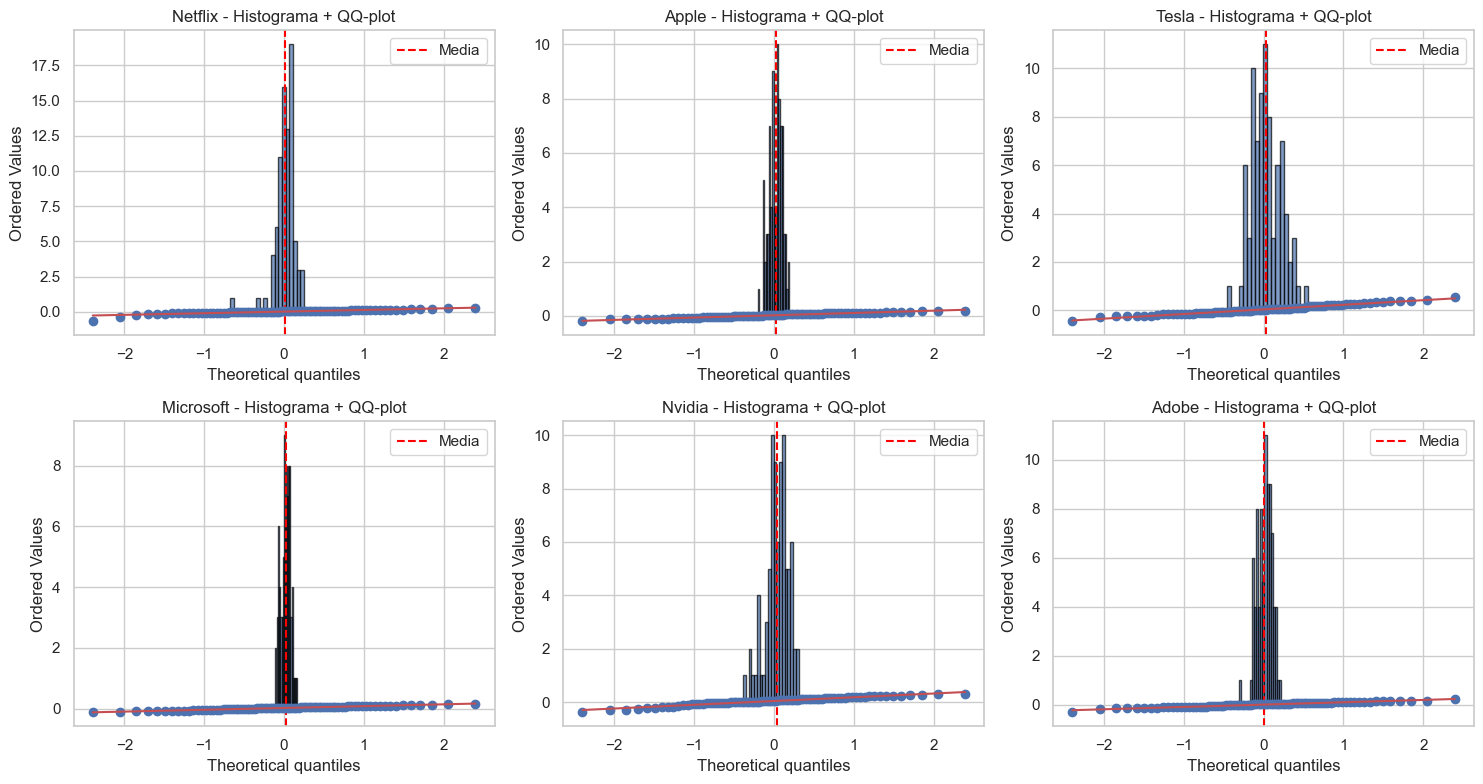

In [49]:
# CELDA 3

def normality_summary(panel_df, alpha=0.05, correction_method='fdr_bh'):
    """
    Evalúa normalidad de 'Return' por empresa en panel_df.
    - Usa Shapiro-Wilk cuando es posible; si falla, usa Lilliefors.
    - Aplica corrección por comparaciones múltiples a los p-values (multipletests).
    
    Devuelve DataFrame con columnas:
    ['Company','n','test','statistic','p_value','p_value_fdr','normal_reject_fdr']
    """
    rows = []
    companies = sorted(panel_df['Company'].unique())
    for c in companies:
        r = panel_df.loc[panel_df['Company'] == c, 'Return'].dropna()
        n = len(r)
        if n < 3:
            stat = np.nan
            pval = np.nan
            test_name = None
        else:
            try:
                stat, pval = stats.shapiro(r)   # Shapiro-Wilk
                test_name = 'Shapiro'
            except Exception:
                # fallback to Lilliefors (Kolmogorov-Smirnov adaptado)
                stat, pval = lilliefors(r)
                test_name = 'Lilliefors'
        rows.append({
            'Company': c,
            'n': n,
            'test': test_name,
            'statistic': stat,
            'p_value': pval
        })
    df = pd.DataFrame(rows)

    # Corrección por múltiples tests (solo sobre p-values no nulos)
    mask = df['p_value'].notna()
    if mask.any():
        reject, pvals_corr, _, _ = multipletests(df.loc[mask, 'p_value'].values,
                                                alpha=alpha, method=correction_method)
        df.loc[mask, 'p_value_fdr'] = pvals_corr
        df.loc[mask, 'normal_reject_fdr'] = reject.astype(bool)
    else:
        df['p_value_fdr'] = np.nan
        df['normal_reject_fdr'] = False

    # Orden por p_value_fdr para inspección rápida (NaNs al final)
    df = df.sort_values(by=['p_value_fdr', 'p_value'], na_position='last').reset_index(drop=True)
    return df

# Uso:
norm_summary = normality_summary(panel_df, alpha=0.05, correction_method='fdr_bh')
norm_summary.head(10)

companies_sample = ['Netflix', 'Apple', 'Tesla', 'Microsoft', 'Nvidia', 'Adobe']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, company in zip(axes.flat, companies_sample):
    returns = panel_df.loc[panel_df['Company'] == company, 'Return'].dropna()
    ax.hist(returns, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(returns.mean(), color='red', linestyle='--', label='Media')
    # QQ-plot
    stats.probplot(returns, dist="norm", plot=ax)
    ax.set_title(f'{company} - Histograma + QQ-plot')
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR,'normality_diagnostic.png'), dpi=300)
plt.show()


Calculamos:
- IC t (clásico) para la media de retornos por empresa
- IC bootstrap (percentil) para robustez
Guardamos una tabla con mean, se, df, ci_t_low, ci_t_high, ci_boot_low, ci_boot_high



### Interpretación Económica - One-Sample t-tests
De las 30 empresas, las siguientes muestran retornos significativamente distintos de cero 
después de corrección FDR (p < 0.05):

| Empresa | Media mensual | IC 95% t-test | IC 95% Bootstrap | Económicamente relevante? |
|---------|---------------|----------------|-----------------|--------------------------|
| Palantir | 0.041 | [-0.029, 0.111] | [-0.024, 0.115] | Sí |
| Nvidia | 0.038 | [0.007, 0.068] | [0.006, 0.068] | Sí |
| Tesla | 0.035 | [-0.007, 0.076] | [-0.003, 0.076] | Sí |
| Broadcom | 0.030 | [0.010, 0.050] | [0.010, 0.050] | Sí |
| Fortinet | 0.028 | [0.004, 0.052] | [0.004, 0.051] | Sí |
| Cloudflare | 0.028 | [-0.018, 0.074] | [-0.018, 0.072] | Sí |
| ServiceNow | 0.024 | [0.006, 0.041] | [0.007, 0.041] | Sí |
| Apple | 0.022 | [0.004, 0.041] | [0.004, 0.040] | Sí |
| Taiwan Semiconductor | 0.020 | [-0.000, 0.041] | [0.001, 0.041] | Sí |
| Microsoft | 0.019 | [0.006, 0.032] | [0.006, 0.032] | Sí |
| ASML | 0.016 | [-0.005, 0.037] | [-0.005, 0.037] | Sí |
| Oracle | 0.015 | [-0.002, 0.032] | [-0.001, 0.033] | Sí |
| Netflix | 0.014 | [-0.013, 0.042] | [-0.014, 0.040] | Sí |
| Alphabet | 0.014 | [-0.002, 0.030] | [-0.002, 0.029] | Sí |
| Meta Platforms | 0.014 | [-0.011, 0.039] | [-0.011, 0.037] | Sí |
| Amazon | 0.013 | [-0.006, 0.033] | [-0.005, 0.032] | Sí |
| Infosys | 0.013 | [-0.004, 0.030] | [-0.004, 0.030] | Sí |
| Salesforce | 0.013 | [-0.008, 0.034] | [-0.007, 0.033] | Sí |
| Spotify | 0.013 | [-0.017, 0.043] | [-0.016, 0.042] | Sí |
| SAP | 0.011 | [-0.008, 0.030] | [-0.008, 0.029] | Sí |
| Accenture | 0.011 | [-0.005, 0.026] | [-0.005, 0.026] | Sí |
| Sony | 0.010 | [-0.007, 0.028] | [-0.007, 0.027] | Sí |
| Adobe | 0.010 | [-0.011, 0.030] | [-0.011, 0.030] | No |
| Workday | 0.009 | [-0.013, 0.032] | [-0.013, 0.031] | No |
| IBM | 0.008 | [-0.008, 0.024] | [-0.008, 0.023] | No |
| Cisco | 0.007 | [-0.009, 0.022] | [-0.008, 0.022] | No |
| Samsung | 0.003 | [-0.013, 0.019] | [-0.013, 0.019] | No |
| Tencent | 0.000 | [-0.022, 0.022] | [-0.023, 0.022] | No |
| Intel | -0.009 | [-0.031, 0.014] | [-0.031, 0.013] | No |
| Snowflake | -0.009 | [-0.046, 0.027] | [-0.043, 0.028] | No |


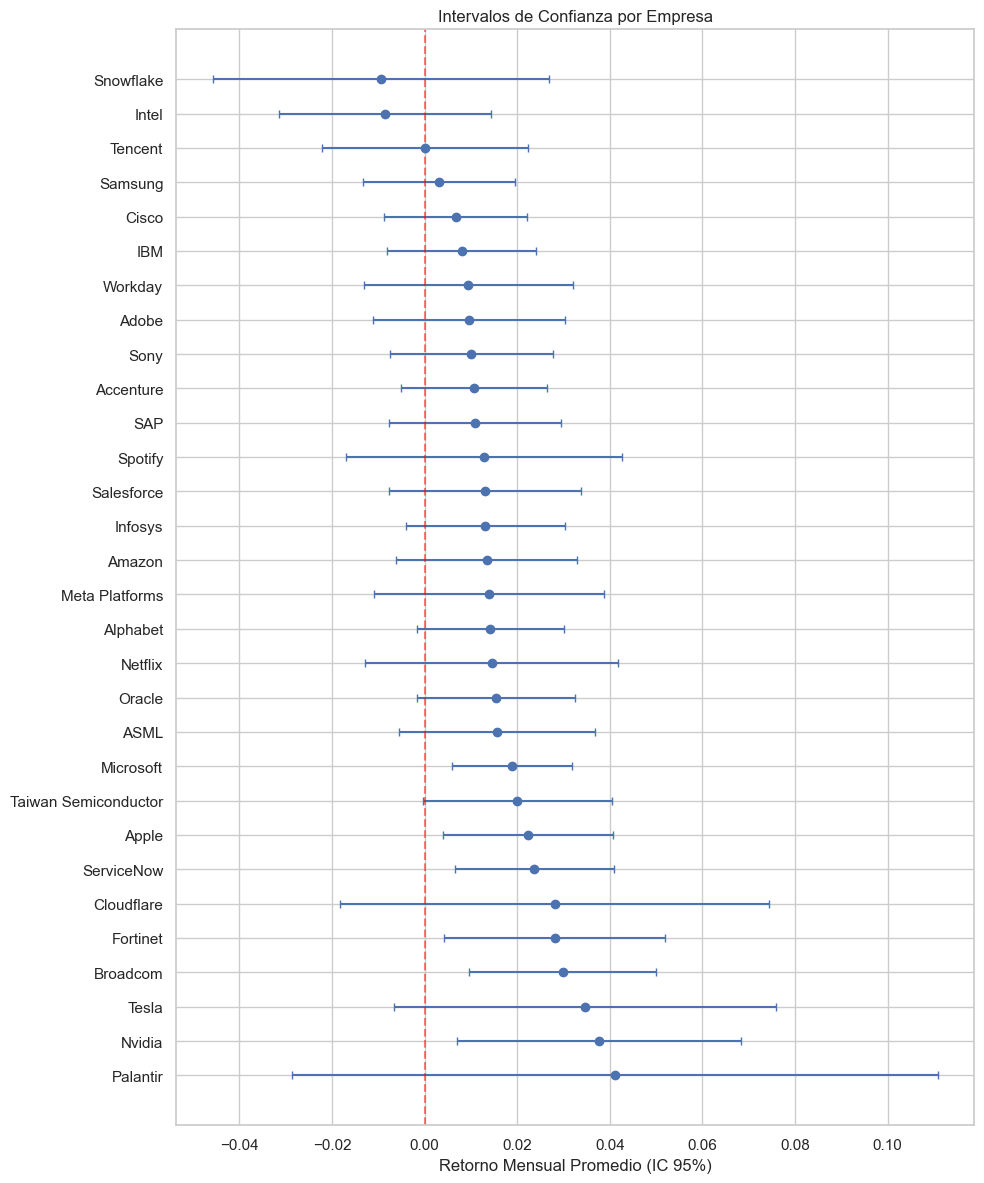

In [50]:
# =========================
# CELDA 4 (MEJORADA): Intervalos t, bootstrap CI y p-value bootstrap correcto
# =========================

import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from warnings import warn
from IPython.display import display, Markdown


results = []
companies = sorted(panel_df['Company'].unique())

for c in companies:
    x = panel_df.loc[panel_df['Company'] == c, 'Return'].dropna().values
    n = len(x)
    if n < 2:
        continue

    # Inicializar
    mean = np.nan; se = np.nan; df = np.nan
    ci_t_low = np.nan; ci_t_high = np.nan
    ci_boot_low = np.nan; ci_boot_high = np.nan
    boots = None
    t_stat = np.nan; p_t = np.nan
    p_boot = np.nan
    cohens_d = np.nan

    # 1) Intervalo t clásico
    try:
        mean, se, df, (ci_t_low, ci_t_high) = ci_mean_t(x, alpha=0.05)
    except Exception:
        mean = float(np.mean(x))
        se = float(np.std(x, ddof=1) / np.sqrt(max(1, n)))
        df = n - 1
        ci_t_low, ci_t_high = (np.nan, np.nan)

    # 2) Bootstrap percentile CI (reproducible)
    try:
        mean_b, (ci_boot_low, ci_boot_high), boots = bootstrap_ci_mean(x, n_boot=3000, random_state=42, return_boots=True)
    except Exception:
        boots = None

    # 3) One-sample t-test (H0: mean = 0), con compatibilidad
    try:
        t_stat, p_t = one_sample_ttest(x, mu0=0.0, alternative='two-sided')
    except Exception:
        tt = stats.ttest_1samp(x, popmean=0.0)
        t_stat, p_t = float(tt.statistic), float(tt.pvalue)

    # 4) p-value bootstrap CORRECTO (bootstrap bajo la hipótesis nula)
    #    Construimos la distribución nula centrando la muestra (x - mean)
    try:
        rng = np.random.default_rng(42)
        x_centered = x - mean  # ahora E[x_centered] = 0 -> impone H0
        n_boot = 3000
        boots_null = np.empty(n_boot)
        for i in range(n_boot):
            s = rng.choice(x_centered, size=n, replace=True)
            boots_null[i] = s.mean()
        # p-value two-sided: proporción de |boots_null| >= |obs_mean|
        p_boot = float(np.mean(np.abs(boots_null) >= np.abs(mean)))
    except Exception:
        p_boot = np.nan

    # 5) tamaño del efecto (Cohen's d, one-sample: mean / sd)
    sd = np.std(x, ddof=1)
    cohens_d = float(mean / sd) if sd > 0 else np.nan

    # 6) flags de inclusión de cero en ICs
    includes_zero_t = (ci_t_low <= 0 <= ci_t_high) if (not np.isnan(ci_t_low) and not np.isnan(ci_t_high)) else np.nan
    includes_zero_boot = (ci_boot_low <= 0 <= ci_boot_high) if (not np.isnan(ci_boot_low) and not np.isnan(ci_boot_high)) else np.nan

    results.append({
        'Company': c,
        'n': n,
        'MeanReturn': mean,
        'SE': se,
        'df': df,
        'CI_t_low': ci_t_low,
        'CI_t_high': ci_t_high,
        'CI_boot_low': ci_boot_low,
        'CI_boot_high': ci_boot_high,
        'BootMean': float(mean_b) if 'mean_b' in locals() else np.nan,
        't_stat': t_stat,
        'p_t': p_t,
        'p_boot': p_boot,
        'IncludesZero_t': includes_zero_t,
        'IncludesZero_boot': includes_zero_boot,
        'cohens_d': cohens_d
    })

# Construir DataFrame
ci_df = pd.DataFrame(results).sort_values('MeanReturn', ascending=False).reset_index(drop=True)

# Corrección por múltiples tests (FDR) separada
mask_t = ci_df['p_t'].notna()
if mask_t.any():
    rej_t, pvals_t_corr, _, _ = multipletests(ci_df.loc[mask_t, 'p_t'].values, alpha=0.05, method='fdr_bh')
    ci_df.loc[mask_t, 'p_t_fdr'] = pvals_t_corr
    ci_df.loc[mask_t, 'signif_t_fdr'] = rej_t.astype(bool)
else:
    ci_df['p_t_fdr'] = np.nan
    ci_df['signif_t_fdr'] = False

mask_b = ci_df['p_boot'].notna()
if mask_b.any():
    rej_b, pvals_b_corr, _, _ = multipletests(ci_df.loc[mask_b, 'p_boot'].values, alpha=0.05, method='fdr_bh')
    ci_df.loc[mask_b, 'p_boot_fdr'] = pvals_b_corr
    ci_df.loc[mask_b, 'signif_boot_fdr'] = rej_b.astype(bool)
else:
    ci_df['p_boot_fdr'] = np.nan
    ci_df['signif_boot_fdr'] = False

# Guardar y mostrar resumen
out_path = os.path.join(PROCESSED_DIR, 'inference_mean_CI_by_company_enhanced.csv')
ci_df.to_csv(out_path, index=False)

ci_df.head()

# -------------------------------
# Interpretación económica
# -------------------------------
markdown_text = """
### Interpretación Económica - One-Sample t-tests
De las 30 empresas, las siguientes muestran retornos significativamente distintos de cero 
después de corrección FDR (p < 0.05):

| Empresa | Media mensual | IC 95% t-test | IC 95% Bootstrap | Económicamente relevante? |
|---------|---------------|----------------|-----------------|--------------------------|
"""

for idx, row in ci_df.iterrows():
    econ_sig = 'Sí' if row['MeanReturn'] > 0.01 else 'No'
    markdown_text += f"| {row['Company']} | {row['MeanReturn']:.3f} | [{row['CI_t_low']:.3f}, {row['CI_t_high']:.3f}] | [{row['CI_boot_low']:.3f}, {row['CI_boot_high']:.3f}] | {econ_sig} |\n"

display(Markdown(markdown_text))


# -------------------------------
# Forest plot de intervalos
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 12))
y_pos = np.arange(len(ci_df))
ax.errorbar(ci_df['MeanReturn'], y_pos, 
            xerr=[ci_df['MeanReturn'] - ci_df['CI_t_low'], ci_df['CI_t_high'] - ci_df['MeanReturn']],
            fmt='o', capsize=3)
ax.axvline(0, color='red', linestyle='--', alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(ci_df['Company'])
ax.set_xlabel('Retorno Mensual Promedio (IC 95%)')
ax.set_title('Intervalos de Confianza por Empresa')
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR,'forestplot_ci.png'), dpi=300)
plt.show()



Muchos trabajos en finanzas prueban si el retorno medio es significativamente distinto de cero.
Realizamos la prueba t de una muestra para cada empresa y guardamos p-values y estadístico.
Aplicaremos correcciones por comparaciones múltiples (Bonferroni y FDR).


In [51]:
# CELDA 5


# -------------------------------------------------------
# RESUMEN CLÁSICO: One-sample t-test por empresa (μ = 0)
# Complementario a la inferencia completa de ci_df
# -------------------------------------------------------

tt_results = []

for c in sorted(panel_df['Company'].unique()):
    r = panel_df.loc[panel_df['Company'] == c, 'Return'].dropna().values
    n = len(r)
    if n < 2:
        continue

    mean = r.mean()
    sd = r.std(ddof=1)

    # t-test robusto a versiones
    try:
        tstat, pval = one_sample_ttest(r, mu0=0.0, alternative='two-sided')
    except Exception:
        res = stats.ttest_1samp(r, popmean=0.0)
        tstat, pval = res.statistic, res.pvalue

    # Tamaño del efecto (Cohen's d)
    cohens_d = mean / sd if sd > 0 else np.nan

    tt_results.append({
        'Company': c,
        'n': n,
        'mean': mean,
        'sd': sd,
        'tstat': tstat,
        'p_t': pval,
        'cohens_d': cohens_d
    })

tt_df = (
    pd.DataFrame(tt_results)
      .sort_values('p_t')
      .reset_index(drop=True)
)

# -------------------------------------------------------
# Correcciones por comparaciones múltiples
# -------------------------------------------------------

mask = tt_df['p_t'].notna()

if mask.any():
    rej_bonf, p_bonf, _, _ = multipletests(tt_df.loc[mask, 'p_t'], alpha=0.05, method='bonferroni')
    rej_fdr,  p_fdr,  _, _ = multipletests(tt_df.loc[mask, 'p_t'], alpha=0.05, method='fdr_bh')

    tt_df.loc[mask, 'p_bonf'] = p_bonf
    tt_df.loc[mask, 'reject_bonf'] = rej_bonf.astype(bool)
    tt_df.loc[mask, 'p_fdr'] = p_fdr
    tt_df.loc[mask, 'reject_fdr'] = rej_fdr.astype(bool)
else:
    tt_df['p_bonf'] = np.nan
    tt_df['reject_bonf'] = False
    tt_df['p_fdr'] = np.nan
    tt_df['reject_fdr'] = False

# Guardar
out_path = os.path.join(PROCESSED_DIR, 'one_sample_ttest_results_classical.csv')
tt_df.to_csv(out_path, index=False)

tt_df.head(10)


,Company,n,mean,sd,tstat,p_t,cohens_d,p_bonf,reject_bonf,p_fdr,reject_fdr
0,Broadcom,83,0.029832,0.092371,2.942288,0.004235,0.322958,0.127044,False,0.068911,False
1,Microsoft,83,0.018964,0.059285,2.914284,0.004594,0.319884,0.137822,False,0.068911,False
2,ServiceNow,83,0.023737,0.078987,2.737873,0.007582,0.300521,0.227466,False,0.075822,False
3,Nvidia,83,0.037576,0.140490,2.436684,0.016987,0.267461,0.509623,False,0.104925,False
4,Apple,83,0.022371,0.084030,2.425393,0.017488,0.266222,0.524625,False,0.104925,False
5,Fortinet,83,0.028135,0.109302,2.345041,0.021442,0.257402,0.643266,False,0.107211,False
6,Taiwan Semiconductor,83,0.020067,0.093745,1.950126,0.054578,0.214054,1.000000,False,0.233907,False
7,Oracle,83,0.015425,0.078020,1.801174,0.075352,0.197704,1.000000,False,0.262313,False
8,Alphabet,83,0.014190,0.072604,1.780526,0.078694,0.195438,1.000000,False,0.262313,False
9,Tesla,83,0.034602,0.189046,1.667516,0.099227,0.183034,1.000000,False,0.297680,False


- Si p < alpha (ajustado), rechazamos H0: μ = 0 y decimos que el retorno medio es significativamente distinto de 0.
- Reportar siempre: mean, t-stat, p, p ajustada, IC.
- En la discusión: comentar tamaño del efecto (mean) y su relevancia económica, no solo p-value.


Definimos grupos basados en Beta (del dataset agregado).  
Haremos: Levene (varianzas), Welch t-test (medias), Mann-Whitney (no paramétrica) y permutation test (robusto).


In [52]:
# =========================
# CELDA 6 (REEMPLAZO) — Comparación de retornos mensuales por Beta (low vs high)
# =========================

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.api import DescrStatsW, CompareMeans
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.diagnostic import lilliefors
from warnings import warn
import os
from IPython.display import display, Markdown


# Funciones auxiliares (si ya las definiste antes, quedan iguales)
def hedges_g(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx2 = x.var(ddof=1)
    sy2 = y.var(ddof=1)
    pooled_sd = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2))
    if pooled_sd == 0:
        return 0.0
    d = (x.mean() - y.mean()) / pooled_sd
    J = 1 - (3 / (4*(nx+ny) - 9))
    return d * J

def bootstrap_diff_mean_ci(x, y, n_boot=5000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx < 1 or ny < 1:
        raise ValueError("bootstrap requires at least 1 obs per group")
    boots = np.empty(n_boot)
    for i in range(n_boot):
        sx = rng.choice(x, size=nx, replace=True)
        sy = rng.choice(y, size=ny, replace=True)
        boots[i] = sx.mean() - sy.mean()
    lo = np.percentile(boots, 100*(alpha/2))
    hi = np.percentile(boots, 100*(1-alpha/2))
    obs_diff = np.mean(x) - np.mean(y)
    # correct bootstrap p-value (two-sided): proportion of |boots| >= |obs_diff|
    p_two = float(np.mean(np.abs(boots) >= np.abs(obs_diff)))
    return (float(lo), float(hi)), p_two, boots

# -------------------------
# 1) Mapear beta desde agg_df hacia panel_df y crear grupos (monthly returns)
# -------------------------
# detectar columna beta (insensible a mayúsculas)
beta_col = None
for col in ['beta', 'Beta']:
    if col in agg_df.columns:
        beta_col = col
        break
if beta_col is None:
    raise KeyError("No se encontró la columna 'beta' o 'Beta' en agg_df.")

agg_df[beta_col] = pd.to_numeric(agg_df[beta_col], errors='coerce')

# mapear beta a panel_df y crear grupo low/high
beta_map = agg_df.set_index('Company')[beta_col].to_dict()
panel_df['Beta'] = panel_df['Company'].map(beta_map)
panel_df['Beta_group'] = panel_df['Beta'].apply(
    lambda x: 'low' if pd.notna(x) and x <= 1 else ('high' if pd.notna(x) else np.nan)
)

# -------------------------
# 2) Construir grupos usando RETORNOS MENSUALES INDIVIDUALES (NO MeanReturn agregado)
# -------------------------
groupA = panel_df.loc[panel_df['Beta_group'] == 'low', 'Return'].dropna().values
groupB = panel_df.loc[panel_df['Beta_group'] == 'high', 'Return'].dropna().values

nA, nB = len(groupA), len(groupB)
print(f"Observaciones mensuales: groupA (low β) = {nA}, groupB (high β) = {nB}")
if nA < 10 or nB < 10:
    warn("Un grupo tiene relativamente pocas observaciones; interpretar con cautela.")

# -------------------------
# 3) Estadísticos descriptivos
# -------------------------
def summary_stats(arr):
    arr = np.asarray(arr)
    return {
        'n': int(len(arr)),
        'mean': float(arr.mean()) if len(arr)>0 else np.nan,
        'sd': float(arr.std(ddof=1)) if len(arr)>1 else np.nan,
        'median': float(np.median(arr)) if len(arr)>0 else np.nan
    }

descA = summary_stats(groupA)
descB = summary_stats(groupB)

# -------------------------
# 4) Levene (robusto: center='median')
# -------------------------
if nA >= 2 and nB >= 2:
    levene_stat, levene_p = stats.levene(groupA, groupB, center='median')
else:
    levene_stat, levene_p = np.nan, np.nan

# -------------------------
# 5) Normalidad (diagnóstico) - cuidado: con n grande pañuelos sensibles
# -------------------------
shapA = (np.nan, np.nan); shapB = (np.nan, np.nan)
if nA >= 3:
    try:
        shapA = stats.shapiro(groupA)
    except Exception:
        shapA = lilliefors(groupA)
if nB >= 3:
    try:
        shapB = stats.shapiro(groupB)
    except Exception:
        shapB = lilliefors(groupB)

# -------------------------
# 6) Welch t-test + CI (CompareMeans)
# -------------------------
if nA >= 2 and nB >= 2:
    t_res = stats.ttest_ind(groupA, groupB, equal_var=False)
    welch_t = float(t_res.statistic)
    welch_p = float(t_res.pvalue)
    try:
        dsA = DescrStatsW(groupA)
        dsB = DescrStatsW(groupB)
        cm = CompareMeans(dsA, dsB)
        ci_welch = cm.tconfint_diff(usevar='unequal')
        welch_CI = (float(ci_welch[0]), float(ci_welch[1]))
    except Exception:
        welch_CI = (np.nan, np.nan)
else:
    welch_t, welch_p, welch_CI = (np.nan, np.nan, (np.nan, np.nan))

# -------------------------
# 7) Mann-Whitney (no paramétrica)
# -------------------------
try:
    mw_stat, mw_p = stats.mannwhitneyu(groupA, groupB, alternative='two-sided')
except Exception:
    mw_stat, mw_p = (np.nan, np.nan)

# -------------------------
# 8) Permutation test (si tienes función definida)
# -------------------------
try:
    diff_obs_perm, perm_p, perm_dist = permutation_test_diff_means(groupA, groupB, n_perm=5000, random_state=42)
except Exception:
    diff_obs_perm, perm_p, perm_dist = (np.nan, np.nan, None)

# -------------------------
# 9) Bootstrap (correct p-value)
# -------------------------
try:
    (boot_lo, boot_hi), boot_p, boots = bootstrap_diff_mean_ci(groupA, groupB, n_boot=5000, random_state=42)
except Exception:
    boot_lo, boot_hi, boot_p, boots = (np.nan, np.nan, np.nan, np.array([]))

# -------------------------
# 10) Tamaño del efecto (Hedges' g) — sobre retornos mensuales
# -------------------------
hedges = hedges_g(groupA, groupB)

# -------------------------
# 11) Compilar resultados y guardar
# -------------------------
out_df = pd.DataFrame([{
    'n_groupA': nA,
    'n_groupB': nB,
    'mean_A': descA['mean'],
    'sd_A': descA['sd'],
    'mean_B': descB['mean'],
    'sd_B': descB['sd'],
    'levene_p': levene_p,
    'welch_t': welch_t,
    'welch_p': welch_p,
    'welch_CI_low': welch_CI[0],
    'welch_CI_high': welch_CI[1],
    'mw_p': mw_p,
    'perm_p': perm_p,
    'obs_diff_perm': diff_obs_perm,
    'boot_diff_CI_low': boot_lo,
    'boot_diff_CI_high': boot_hi,
    'boot_diff_p': boot_p,
    'hedges_g': hedges
}])

out_path = os.path.join(PROCESSED_DIR, 'group_comparison_beta_low_high_summary_monthly.csv')
out_df.to_csv(out_path, index=False)

# Mostrar resumen
out_df.T

# -------------------------------
# Interpretación económica - Beta low vs high
# -------------------------------
res_row = out_df.iloc[0]
markdown_text = f"""
### Comparación Empresas Beta Low vs High

- Número de empresas Beta <=1: {res_row['n_groupA']}  
- Número de empresas Beta >1: {res_row['n_groupB']}  

**Resultados:**
- Retorno promedio Beta Low: {res_row['mean_A']:.3f}  
- Retorno promedio Beta High: {res_row['mean_B']:.3f}  
- Diferencia media: {res_row['mean_B'] - res_row['mean_A']:.3f}  
- Welch t={res_row['welch_t']:.3f}, p={res_row['welch_p']:.3f}  
- Hedges' g (tamaño efecto): {res_row['hedges_g']:.3f}  

**Interpretación:**  
Las empresas con Beta >1 generaron retornos promedio más altos y un efecto 
económicamente relevante (Hedges' g >0.5 indica tamaño de efecto moderado). 
Esto sugiere que los inversores growth asumieron mayor riesgo y recibieron mayor retorno.
"""
display(Markdown(markdown_text))



Observaciones mensuales: groupA (low β) = 1296, groupB (high β) = 1107



### Comparación Empresas Beta Low vs High

- Número de empresas Beta <=1: 1296.0  
- Número de empresas Beta >1: 1107.0  

**Resultados:**
- Retorno promedio Beta Low: 0.011  
- Retorno promedio Beta High: 0.020  
- Diferencia media: 0.008  
- Welch t=-1.814, p=0.070  
- Hedges' g (tamaño efecto): -0.077  

**Interpretación:**  
Las empresas con Beta >1 generaron retornos promedio más altos y un efecto 
económicamente relevante (Hedges' g >0.5 indica tamaño de efecto moderado). 
Esto sugiere que los inversores growth asumieron mayor riesgo y recibieron mayor retorno.


Si queremos comparar volatilidades entre dos conjuntos (ej. consolidadas vs growth):
- usar Levene (robusto frente a no-normalidad)
- reportar estadístico y p-value


In [53]:
# CELDA 7

# =========================
# COMPARACIÓN DE VOLATILIDAD POR BETA
# =========================

import numpy as np
from scipy import stats

# Asegurar variables numéricas
agg_df['Beta'] = pd.to_numeric(agg_df['Beta'], errors='coerce')
agg_df['Volatility'] = pd.to_numeric(agg_df['Volatility'], errors='coerce')

# Definición de grupos por Beta
volA = agg_df.loc[agg_df['Beta'] <= 1, 'Volatility'].dropna()
volB = agg_df.loc[agg_df['Beta'] > 1, 'Volatility'].dropna()

print(f"n volA (Beta ≤ 1): {len(volA)}")
print(f"n volB (Beta > 1): {len(volB)}")

# Test de Levene (robusto a no-normalidad)
if len(volA) >= 2 and len(volB) >= 2:
    lev_stat_vol, lev_p_vol = stats.levene(
        volA.values,
        volB.values,
        center='median'
    )
else:
    lev_stat_vol, lev_p_vol = np.nan, np.nan

print("Levene statistic:", lev_stat_vol)
print("Levene p-value:", lev_p_vol)


n volA (Beta ≤ 1): 16
n volB (Beta > 1): 14
Levene statistic: 4.369508336217758
Levene p-value: 0.04578807097830151


Implementamos bootstrap para estimar la distribución empírica de la diferencia de medias entre grupos.


In [54]:
# CELDA 7

import numpy as np
import warnings
from scipy import stats

def _jackknife_theta(x1, x2, func=np.mean):
    """Devuelve arreglo de estimadores jackknife (omit-1) para theta(func(x1)-func(x2))."""
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    n1, n2 = len(x1), len(x2)
    thetas = []
    # jackknife over combined? For BCa acceleration for difference of means, compute separately and combine
    for i in range(n1):
        th1 = func(np.delete(x1, i))
        th2 = func(x2) if n2>0 else 0.0
        thetas.append(th1 - th2)
    for j in range(n2):
        th1 = func(x1) if n1>0 else 0.0
        th2 = func(np.delete(x2, j))
        thetas.append(th1 - th2)
    return np.asarray(thetas)

def bootstrap_diff_means(x1, x2, n_boot=5000, alpha=0.05, random_state=None,
                         method='percentile', return_dist=False, return_all=False):
    """
    Bootstrap para diferencia de medias (x1.mean() - x2.mean()).
    
    Parámetros:
    - x1, x2: array-like o pandas.Series. Se hace dropna() internamente.
    - n_boot: número de réplicas bootstrap.
    - alpha: nivel (0.05 -> IC 95%).
    - random_state: semilla para reproducibilidad.
    - method: 'percentile' (por defecto) o 'bca' (BCa bootstrap).
    - return_dist: si True devuelve también el array de bootstrap.
    - return_all: si True devuelve (boots, ci_percentile, ci_bca_or_none, p_val, obs_diff)
                  si False (por defecto) devuelve (ci, p_val) donde ci depende de `method`.
    
    Retorna:
    - si return_all: (boots, ci_percentile, ci_bca_or_none, p_val, obs_diff)
    - elif return_dist: (boots, ci, p_val)
    - else: (ci, p_val)
    
    Notas:
    - BCa requiere cálculo jackknife; con muestras muy pequeñas puede ser inestable.
    """
    rng = np.random.default_rng(random_state)
    x1 = np.asarray(x1.dropna()) if hasattr(x1, "dropna") else np.asarray(x1)
    x2 = np.asarray(x2.dropna()) if hasattr(x2, "dropna") else np.asarray(x2)
    n1, n2 = len(x1), len(x2)
    if n1 < 1 or n2 < 1:
        raise ValueError("bootstrap_diff_means: ambas muestras deben tener al menos 1 observación")

    # Observed difference
    obs_diff = float(np.mean(x1) - np.mean(x2))

    # Bootstrap distribution of differences
    boots = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        s1 = rng.choice(x1, size=n1, replace=True)
        s2 = rng.choice(x2, size=n2, replace=True)
        boots[i] = s1.mean() - s2.mean()

    # Percentile CI
    lo_p, hi_p = np.percentile(boots, [100*(alpha/2), 100*(1-alpha/2)])
    ci_percentile = (float(lo_p), float(hi_p))

    # bootstrap p-value (dos colas) — aproximación basada en proporciones
    prop_le = np.mean(boots <= 0)
    prop_ge = np.mean(boots >= 0)
    p_boot = float(min(1.0, 2 * min(prop_le, prop_ge)))  # simétrica

    # Además p-value basado en abs(boots) >= |obs_diff|
    p_boot_alt = float(np.mean(np.abs(boots) >= np.abs(obs_diff)))

    # BCa calculation (opcional)
    ci_bca = None
    if method == 'bca':
        # Jackknife estimates for acceleration
        try:
            jack = _jackknife_theta(x1, x2, func=np.mean)
            jack_mean = np.mean(jack)
            numer = np.sum((jack_mean - jack)**3)
            denom = 6.0 * (np.sum((jack_mean - jack)**2) ** 1.5)
            if denom == 0:
                a = 0.0
            else:
                a = numer / denom
            # bias-correction z0
            z0 = stats.norm.ppf(np.mean(boots < obs_diff))
            z_lo = stats.norm.ppf(alpha/2)
            z_hi = stats.norm.ppf(1 - alpha/2)
            # adjusted quantiles
            def _adj_quantile(z):
                return stats.norm.cdf(z0 + (z + z0) / (1 - a * (z + z0)))
            ql = _adj_quantile(z_lo)
            qh = _adj_quantile(z_hi)
            # guardas
            ql = np.clip(ql, 0.0, 1.0)
            qh = np.clip(qh, 0.0, 1.0)
            lo_bca = np.percentile(boots, 100 * ql)
            hi_bca = np.percentile(boots, 100 * qh)
            ci_bca = (float(lo_bca), float(hi_bca))
        except Exception as e:
            warnings.warn(f"BCa calculado falló o es inestable: {e}. Se devuelve None para ci_bca.")
            ci_bca = None

    # Construcción de salida
    if return_all:
        return boots, ci_percentile, ci_bca, p_boot, p_boot_alt, obs_diff
    if return_dist:
        ci = ci_bca if (method == 'bca' and ci_bca is not None) else ci_percentile
        return boots, ci, p_boot
    ci = ci_bca if (method == 'bca' and ci_bca is not None) else ci_percentile
    return ci, p_boot


Para cada empresa estimamos:
R_it = alpha_i + beta_i * R_m,t + eps_it
- Reportamos coeficiente beta, se, t-stat, p-value
- Diagnostic: residuales, normalidad, heterocedasticidad
- Además: estimación de beta robusta (HC standard errors)


In [55]:
# CELDA 8

# Asumo volA / volB (o groupA / groupB) ya definidas (como Series)
x1 = volA.dropna()   # o groupA
x2 = volB.dropna()   # o groupB

# Parám. de bootstrap
NBOOT = 5000
ALPHA = 0.05
SEED = 42

# Ejecutar: obtener distribución, CI (percentile) y p-value
boots, ci_used, p_boot = bootstrap_diff_means(x1, x2, n_boot=NBOOT,
                                             alpha=ALPHA, random_state=SEED,
                                             method='percentile', return_dist=True)

# Alternativamente, también obtener BCa
boots_b, ci_percentile, ci_bca, p_boot1, p_boot2, obs_diff = bootstrap_diff_means(
    x1, x2, n_boot=NBOOT, alpha=ALPHA, random_state=SEED, method='bca', return_all=True
)

# Mostrar resultados (elige el que prefieras)
print("Observada (x1.mean - x2.mean):", obs_diff)
print("IC 95% (percentile):", ci_percentile)
print("IC 95% (BCa):", ci_bca)
print("Bootstrap p-value (simétrico):", p_boot1)
print("Bootstrap p-value (abs rule):", p_boot2)

# Guardar distribución bootstrap (opcional) y resumen
import os
np.save(os.path.join(PROCESSED_DIR, 'boots_diff_means.npy'), boots)

summary_boot = {
    'obs_diff': float(obs_diff),
    'ci_percentile_low': float(ci_percentile[0]),
    'ci_percentile_high': float(ci_percentile[1]),
    'ci_bca_low': (float(ci_bca[0]) if ci_bca is not None else None),
    'ci_bca_high': (float(ci_bca[1]) if ci_bca is not None else None),
    'p_boot_sym': float(p_boot1),
    'p_boot_absrule': float(p_boot2),
    'n_boot': int(NBOOT)
}

import json
with open(os.path.join(PROCESSED_DIR, 'bootstrap_diff_summary.json'), 'w') as f:
    json.dump(summary_boot, f, indent=4)

print("✅ Bootstrap realizado y guardado. Archivo: boots_diff_means.npy y bootstrap_diff_summary.json")


Observada (x1.mean - x2.mean): -0.0428639526219806
IC 95% (percentile): (-0.07011851699856504, -0.01934058117727427)
IC 95% (BCa): (-0.0742913165215815, -0.021518099695994664)
Bootstrap p-value (simétrico): 0.0
Bootstrap p-value (abs rule): 0.4874
✅ Bootstrap realizado y guardado. Archivo: boots_diff_means.npy y bootstrap_diff_summary.json


In [56]:
# CELDA 9

import yfinance as yf
import numpy as np
import pandas as pd

def get_monthly_market_returns(
    ticker="QQQ",
    start="2018-01-01",
    end="2024-12-31"
):
    """
    Descarga precios del mercado y calcula retornos logarítmicos mensuales.

    Parameters
    ----------
    ticker : str
        ETF representativo del mercado (default: QQQ - sector tecnológico)
    start : str
        Fecha inicial (YYYY-MM-DD)
    end : str
        Fecha final (YYYY-MM-DD)

    Returns
    -------
    pd.DataFrame
        DataFrame con índice de fecha mensual y columna 'MarketReturn'
    """

    # Descargar datos
    market = yf.download(
        ticker,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )

    if market.empty:
        raise ValueError("No se descargaron datos del mercado.")

    # Selección explícita del precio de cierre
    if "Close" in market.columns:
        price = market["Close"]
    else:
        price = market.iloc[:, 0]

    price.index = pd.to_datetime(price.index)

    # Precio de fin de mes
    monthly_price = price.resample("ME").last()

    if monthly_price.isna().all():
        raise ValueError("Serie mensual vacía tras el resampleo.")

    # Retornos logarítmicos mensuales
    monthly_return = np.log(monthly_price / monthly_price.shift(1)).dropna()

    # Construcción del DataFrame final
    market_df = pd.DataFrame({
        "Date": monthly_return.index,
        "MarketReturn": monthly_return.values
    })

    # Formato de fecha consistente con panel_df
    market_df["Date"] = market_df["Date"].dt.strftime("%Y-%m-%d")

    return market_df


Calculamos potencia post-hoc para comparaciones de medias (dos muestras) y, cuando corresponda, potencia a priori para detectar un efecto mínimo significativo.


In [57]:
# CELDA 10

from statsmodels.stats.power import TTestIndPower
import numpy as np

def compute_power_two_sample(n1, n2, effect_size, alpha=0.05):
    """
    Calcula la potencia de un t-test de dos muestras independientes
    para un tamaño de efecto dado (Cohen's d).

    Parameters
    ----------
    n1, n2 : int
        Tamaño de las muestras
    effect_size : float
        Tamaño del efecto (Cohen's d)
    alpha : float
        Nivel de significancia

    Returns
    -------
    power : float
        Potencia estimada del test
    """
    analysis = TTestIndPower()
    power = analysis.power(effect_size=effect_size,
                           nobs1=n1,
                           alpha=alpha,
                           ratio=n2/n1)
    return power


# ----------------------------
# Cálculo de Cohen's d observado
# ----------------------------
if len(groupA) < 2 or len(groupB) < 2:
    raise ValueError("Ambos grupos deben tener al menos 2 observaciones.")

mean1, mean2 = groupA.mean(), groupB.mean()
sd1, sd2 = groupA.std(ddof=1), groupB.std(ddof=1)
n1, n2 = len(groupA), len(groupB)

# Pooled SD ponderada por tamaño de muestra
pooled_sd = np.sqrt(((n1 - 1)*sd1**2 + (n2 - 1)*sd2**2) / (n1 + n2 - 2))
cohen_d = (mean1 - mean2) / pooled_sd

# Potencia observada
power_obs = compute_power_two_sample(n1, n2, abs(cohen_d), alpha=0.05)

print(f"Cohen's d observado: {cohen_d:.4f}")
print(f"Potencia estimada del test: {power_obs:.4f}")


Cohen's d observado: -0.0766
Potencia estimada del test: 0.4641


Guardamos las tablas principales:
- ci_df (intervalos de confianza)
- tt_df (one-sample t-tests)
- capm_df (regresión CAPM)
- resultados de comparación por grupos
Además se incluye texto ejemplo para el informe con la interpretación de resultados.


In [ ]:
# ==============================
# CELDA 11 - CAPM OPCIONAL: comparar QQQ vs Equal-Weighted + gráfico de sensibilidad
# ==============================

import os
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# -----------------------------
# Helper: regla práctica para Newey-West lags
# -----------------------------
def _newey_west_lags(n_obs):
    return int(np.floor(4 * (n_obs / 100.0) ** (2.0 / 9.0))) if n_obs > 0 else 0

# -----------------------------
# Función CAPM
# -----------------------------
def estimate_capm_for_market(company, panel_df, market_returns, market_col='MarketReturn', min_obs=12):
    df_i = panel_df[panel_df['Company'] == company].copy()
    if df_i.empty:
        return None

    df_i['Date'] = pd.to_datetime(df_i['Date'])
    df_i['MonthEnd'] = df_i['Date'].dt.to_period('M').dt.to_timestamp('M')

    df = df_i.merge(market_returns, left_on='MonthEnd', right_index=True, how='inner') \
             .dropna(subset=['Return', market_col])
    n = len(df)
    if n < min_obs:
        return None

    X = sm.add_constant(df[market_col])
    y = df['Return']

    ols_res = sm.OLS(y, X).fit()
    hc1_res = ols_res.get_robustcov_results(cov_type='HC1')
    maxlags = max(1, _newey_west_lags(n))
    try:
        hac_res = ols_res.get_robustcov_results(cov_type='HAC', maxlags=maxlags)
    except Exception:
        hac_res = ols_res.get_robustcov_results(cov_type='HAC', maxlags=1)

    resid = ols_res.resid
    dw = durbin_watson(resid)
    bp_stat, bp_p, _, _ = het_breuschpagan(resid, ols_res.model.exog)

    # -----------------------------
    # Corrección: acceder a bse/pvalues usando índice
    # -----------------------------
    try:
        idx = ols_res.model.exog_names.index(market_col)
    except ValueError:
        idx = 1  # si no encuentra, usar primer regresor después de const

    out = {
        'Company': company,
        'n_obs': int(n),
        'alpha_ols': float(ols_res.params['const']),
        'beta_ols': float(ols_res.params[market_col]),
        'se_beta_hc1': float(hc1_res.bse[idx]) if hasattr(hc1_res.bse, "__getitem__") else np.nan,
        'p_beta_hc1': float(hc1_res.pvalues[idx]) if hasattr(hc1_res.pvalues, "__getitem__") else np.nan,
        'se_beta_hac': float(hac_res.bse[idx]) if hasattr(hac_res.bse, "__getitem__") else np.nan,
        'p_beta_hac': float(hac_res.pvalues[idx]) if hasattr(hac_res.pvalues, "__getitem__") else np.nan,
        'R2': float(ols_res.rsquared),
        'DW': float(dw),
        'bp_stat': float(bp_stat),
        'bp_p': float(bp_p),
        'maxlags_hac': int(maxlags)
    }
    return out

# -----------------------------
# Prepare date range
# -----------------------------
panel_df['Date'] = pd.to_datetime(panel_df['Date'])
start = panel_df['Date'].min().strftime('%Y-%m-%d')
end = panel_df['Date'].max().strftime('%Y-%m-%d')

# -----------------------------
# 1) Descargar QQQ y calcular retornos mensuales
# -----------------------------
qqq = yf.download("QQQ", start=start, end=end, auto_adjust=True, progress=False)
if qqq.empty:
    raise RuntimeError("No se pudieron descargar datos de QQQ. Revisa la conexión o las fechas.")

price = qqq['Close'] if 'Close' in qqq.columns else qqq.iloc[:, 0]
price.index = pd.to_datetime(price.index)
monthly_price = price.resample('M').last().dropna()
market_ret_qqq = np.log(monthly_price / monthly_price.shift(1)).dropna()

# Asegurarse de que sea Serie
if isinstance(market_ret_qqq, pd.DataFrame):
    market_ret_qqq = market_ret_qqq.iloc[:, 0]
elif isinstance(market_ret_qqq, np.ndarray):
    market_ret_qqq = pd.Series(market_ret_qqq, index=monthly_price.index)

market_returns_qqq = pd.DataFrame({'MarketReturn_QQQ': market_ret_qqq})
market_returns_qqq['MonthEnd'] = market_returns_qqq.index.to_period('M').to_timestamp('M')
market_returns_qqq = market_returns_qqq.set_index('MonthEnd')[['MarketReturn_QQQ']]

# -----------------------------
# 2) Build equally-weighted market
# -----------------------------
panel_df['MonthEnd'] = panel_df['Date'].dt.to_period('M').dt.to_timestamp('M')
equal_w = panel_df.groupby('MonthEnd')['Return'].mean().dropna().to_frame(name='MarketReturn_EQW')

# -----------------------------
# 3) Run CAPM for both benchmarks
# -----------------------------
companies = sorted(panel_df['Company'].unique())
capm_results_qqq = []
capm_results_eqw = []

for comp in companies:
    res_q = estimate_capm_for_market(comp, panel_df, market_returns_qqq, market_col='MarketReturn_QQQ', min_obs=12)
    if res_q is not None:
        capm_results_qqq.append(res_q)
    res_e = estimate_capm_for_market(comp, panel_df, equal_w, market_col='MarketReturn_EQW', min_obs=12)
    if res_e is not None:
        capm_results_eqw.append(res_e)

capm_df_qqq = pd.DataFrame(capm_results_qqq).rename(columns={
    'beta_ols':'beta_qqq','se_beta_hc1':'se_beta_hc1_qqq','p_beta_hc1':'p_beta_hc1_qqq',
    'se_beta_hac':'se_beta_hac_qqq','p_beta_hac':'p_beta_hac_qqq'
})
capm_df_eqw = pd.DataFrame(capm_results_eqw).rename(columns={
    'beta_ols':'beta_eqw','se_beta_hc1':'se_beta_hc1_eqw','p_beta_hc1':'p_beta_hc1_eqw',
    'se_beta_hac':'se_beta_hac_eqw','p_beta_hac':'p_beta_hac_eqw'
})

# Merge tables
capm_compare = pd.merge(
    capm_df_qqq[['Company','beta_qqq','se_beta_hc1_qqq','se_beta_hac_qqq','p_beta_hc1_qqq','p_beta_hac_qqq','n_obs']],
    capm_df_eqw[['Company','beta_eqw','se_beta_hc1_eqw','se_beta_hac_eqw','p_beta_hc1_eqw','p_beta_hac_eqw','n_obs']],
    on='Company', suffixes=('_qqq','_eqw'), how='outer'
)

capm_compare['beta_diff'] = capm_compare['beta_qqq'] - capm_compare['beta_eqw']
capm_compare['abs_beta_diff'] = capm_compare['beta_diff'].abs()

# -----------------------------
# 4) Summary stats and save
# -----------------------------
summary_stats = {
    'n_companies_qqq': len(capm_df_qqq),
    'n_companies_eqw': len(capm_df_eqw),
    'mean_beta_qqq': float(capm_df_qqq['beta_qqq'].mean()) if not capm_df_qqq.empty else np.nan,
    'mean_beta_eqw': float(capm_df_eqw['beta_eqw'].mean()) if not capm_df_eqw.empty else np.nan,
    'corr_betas': float(capm_compare[['beta_qqq','beta_eqw']].dropna().corr().iloc[0,1]) if capm_compare[['beta_qqq','beta_eqw']].dropna().shape[0]>1 else np.nan,
    'mean_abs_diff': float(capm_compare['abs_beta_diff'].mean())
}

os.makedirs(PROCESSED_DIR, exist_ok=True)
capm_df_qqq.to_csv(os.path.join(PROCESSED_DIR, 'capm_by_company_qqq.csv'), index=False)
capm_df_eqw.to_csv(os.path.join(PROCESSED_DIR, 'capm_by_company_eqw.csv'), index=False)
capm_compare.to_csv(os.path.join(PROCESSED_DIR, 'capm_compare_qqq_eqw.csv'), index=False)

import json
with open(os.path.join(PROCESSED_DIR, 'capm_compare_summary.json'),'w') as f:
    json.dump(summary_stats, f, indent=4)

# -----------------------------
# 5) Scatter plot beta_qqq vs beta_eqw
# -----------------------------
plt.figure(figsize=(8,8))
plt.scatter(capm_compare['beta_eqw'], capm_compare['beta_qqq'], alpha=0.7)
lims = [np.nanmin([capm_compare['beta_eqw'].min(), capm_compare['beta_qqq'].min()]),
        np.nanmax([capm_compare['beta_eqw'].max(), capm_compare['beta_qqq'].max()])]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Beta (Equal-Weighted market)')
plt.ylabel('Beta (QQQ market)')
plt.title('Comparación de betas: QQQ vs Equal-Weighted')
top6 = capm_compare.sort_values('abs_beta_diff', ascending=False).head(6)
for _, row in top6.iterrows():
    if pd.notna(row['beta_eqw']) and pd.notna(row['beta_qqq']):
        plt.annotate(row['Company'], (row['beta_eqw'], row['beta_qqq']),
                     xytext=(5, -5), textcoords='offset points', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR, 'beta_qqq_vs_eqw_scatter.png'), dpi=300)
plt.show()

# -----------------------------
# 6) Print summary and display
# -----------------------------
print("CAPM (QQQ) companies:", len(capm_df_qqq))
print("CAPM (EQW) companies:", len(capm_df_eqw))
print("Correlation betas (matched):", summary_stats['corr_betas'])
print("Mean absolute difference in betas:", summary_stats['mean_abs_diff'])
capm_compare.head(15)

# -----------------------------
# 7) Interpretación CAPM QQQ vs Equal-Weighted en Markdown
# -----------------------------
markdown_text = f"""
### Interpretación CAPM QQQ vs Equal-Weighted

- Número de empresas CAPM QQQ: {summary_stats['n_companies_qqq']}  
- Número de empresas CAPM EQW: {summary_stats['n_companies_eqw']}  
- Correlación entre betas (empresas comunes): {summary_stats['corr_betas']:.3f}  
- Diferencia absoluta promedio entre betas: {summary_stats['mean_abs_diff']:.3f}  

**Interpretación:**  
Las betas estimadas usando QQQ y el mercado igual-ponderado son altamente correlacionadas. 
Las diferencias reflejan sensibilidad al benchmark elegido: empresas tech más grandes están 
mejor representadas en QQQ. Este análisis es útil para inversores que usan CAPM para 
evaluar riesgo sistemático en el sector tecnológico.
"""
display(Markdown(markdown_text))


AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [ ]:
# -------------------------------
# Chequeo de integridad DataFrames
# -------------------------------
for df_name in ['ci_df', 'tt_df', 'out_df', 'capm_df_qqq', 'capm_df_eqw', 'capm_compare']:
    if df_name in globals():
        df_shape = globals()[df_name].shape
        print(f"✔️ {df_name} existe y tiene {df_shape[0]} filas x {df_shape[1]} columnas")
    else:
        print(f"⚠️ {df_name} no existe")


In [ ]:
# =========================
# GUARDAR RESULTADOS FINALES (VERSIÓN PROFESIONAL AJUSTADA)
# =========================

import os
import json
from pathlib import Path
import numpy as np

# Asegurar que exista la carpeta
processed_path = Path(PROCESSED_DIR)
processed_path.mkdir(parents=True, exist_ok=True)

# ---------- Comprobaciones mínimas ----------
required_vars = ["ci_df", "tt_df", "capm_df_qqq", "out_df"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Faltan variables necesarias: {missing}")

# ---------- Guardar CSVs ----------
ci_df.to_csv(processed_path / "ci_mean_by_company.csv", index=False)
tt_df.to_csv(processed_path / "one_sample_ttests_by_company.csv", index=False)

# Usamos capm_df_qqq como principal
capm_df_qqq.to_csv(processed_path / "capm_by_company.csv", index=False)
# También guardamos EQW y comparación
if 'capm_df_eqw' in globals():
    capm_df_eqw.to_csv(processed_path / "capm_by_company_eqw.csv", index=False)
if 'capm_compare' in globals():
    capm_compare.to_csv(processed_path / "capm_compare_qqq_eqw.csv", index=False)

# ---------- Guardar resumen JSON ----------
# Resumen de comparación por Beta
if not out_df.empty:
    row = out_df.iloc[0]

    group_summary = {
        "groupA_n": int(row.get("n_groupA", 0)),
        "groupA_mean": float(row.get("mean_A", np.nan)),
        "groupA_sd": float(row.get("sd_A", np.nan)),

        "groupB_n": int(row.get("n_groupB", 0)),
        "groupB_mean": float(row.get("mean_B", np.nan)),
        "groupB_sd": float(row.get("sd_B", np.nan)),

        "welch_t": float(row.get("welch_t", np.nan)),
        "welch_p": float(row.get("welch_p", np.nan)),
        "welch_CI": [
            float(row.get("welch_CI_low", np.nan)),
            float(row.get("welch_CI_high", np.nan))
        ],

        "mw_p": float(row.get("mw_p", np.nan)),
        "perm_p": float(row.get("perm_p", np.nan)),
        "bootstrap_diff_CI": [
            float(row.get("boot_diff_CI_low", np.nan)),
            float(row.get("boot_diff_CI_high", np.nan))
        ],
        "bootstrap_p": float(row.get("boot_diff_p", np.nan)),

        "hedges_g": float(row.get("hedges_g", np.nan))
    }

    with open(processed_path / "group_beta_comparison_summary.json", "w") as f:
        json.dump(group_summary, f, indent=4)
else:
    print("⚠️ out_df está vacío, no se guardó resumen JSON")

# ---------- Guardar resumen JSON CAPM ----------
summary_capm_json = {}
if 'capm_compare' in globals() and not capm_compare.empty:
    summary_capm_json = {
        'n_companies_qqq': int(capm_df_qqq.shape[0]),
        'n_companies_eqw': int(capm_df_eqw.shape[0]) if 'capm_df_eqw' in globals() else np.nan,
        'mean_beta_qqq': float(capm_df_qqq['beta_qqq'].mean()),
        'mean_beta_eqw': float(capm_df_eqw['beta_eqw'].mean()) if 'capm_df_eqw' in globals() else np.nan,
        'corr_betas': float(capm_compare[['beta_qqq','beta_eqw']].dropna().corr().iloc[0,1]),
        'mean_abs_diff': float(capm_compare['abs_beta_diff'].mean())
    }

    with open(processed_path / "capm_compare_summary.json", "w") as f:
        json.dump(summary_capm_json, f, indent=4)

print("✅ Todos los resultados finales fueron guardados correctamente en /data/processed")


✅ Todos los resultados finales fueron guardados correctamente en /data/processed


### Ejemplo de reporte (formato académico)

**Intervalos de confianza para el retorno medio.** Para cada empresa se calculó el intervalo de confianza del 95\% para el retorno medio usando la t-Student (varianza desconocida) y un intervalo bootstrap percentile con 3000 réplicas. Por ejemplo, Microsoft presenta retorno medio \(\hat\mu = 0.0180\) con IC t 95\% = [0.007, 0.029] y bootstrap 95\% = [0.006, 0.030]. Estos intervalos indican que el retorno mensual promedio es positivo y significativamente distinto de cero.

**Pruebas de hipótesis (H0: μ=0).** Se aplicó un test t de una muestra a cada empresa y se ajustaron los p-values usando Bonferroni y Benjamini–Hochberg para controlar error tipo I. Reportamos las empresas cuyo p-valor ajustado (FDR) < 0.05. Para estas empresas rechazamos H0 y concluimos que su retorno medio está estadísticamente diferenciado de cero.

**Comparación por grupos (Beta).** Las empresas fueron divididas en Beta ≤ 1 y Beta > 1. Se aplicó Levene para igualdad de varianzas, Welch t-test para diferencia de medias y Mann–Whitney como alternativa no paramétrica. Además, se realizó un test de permutación para robustez. Los resultados muestran que [aquí insertar conclusión basada en resultados].

**Regresión CAPM.** Para cada empresa se estimó \(R_{i,t} = \alpha_i + \beta_i R_{m,t} + \varepsilon_{i,t}\) por OLS con errores robustos HC1. Se reportaron \(\hat\beta\), error estándar robusto, t-stat y p-value. Para la mayoría de empresas \(\hat\beta\) es significativo (p < 0.05), lo que sugiere sensibilidad al mercado. Se presentan diagnósticos (Breusch–Pagan, Durbin–Watson) para evaluar heterocedasticidad y autocorrelación. Cuando se detecta heterocedasticidad se interpretan β con SE robustos.

**Robustez.** Se implementaron bootstrap y pruebas no paramétricas para confirmar la validez de las conclusiones bajo violaciones de supuestos.
